# Shopping Frequency Analysis

This notebook analyzes household shopping frequency patterns by examining the distribution of time between shopping trips (based on basket_id).

## Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from completejourney_py import get_data

# Set plotting style
plt.style.use('default')
sns.set_palette("viridis")

In [2]:
# Load the required datasets
data = get_data(["transactions", "demographics"])
transactions = data["transactions"]
demographics = data["demographics"]

print(f"Loaded {len(transactions):,} transaction records")
print(f"Loaded {len(demographics):,} household records")

Loaded 1,469,307 transaction records
Loaded 801 household records


## Data Preparation: Calculate Shopping Trips

In [3]:
# Extract date from transaction_timestamp for trip grouping
transactions['date'] = transactions['transaction_timestamp'].dt.date

# Create shopping trip dataset (unique basket_id represents one shopping trip)
shopping_trips = (
    transactions
    .groupby(['household_id', 'basket_id', 'date'])
    .agg({
        'sales_value': 'sum',
        'quantity': 'sum',
        'product_id': 'nunique'
    })
    .reset_index()
    .rename(columns={
        'sales_value': 'trip_value',
        'quantity': 'total_items',
        'product_id': 'unique_products'
    })
)

print(f"Total shopping trips: {len(shopping_trips):,}")
print(f"Average trip value: ${shopping_trips['trip_value'].mean():.2f}")
print(f"Average items per trip: {shopping_trips['total_items'].mean():.1f}")
print(f"Date range: {shopping_trips['date'].min()} to {shopping_trips['date'].max()}")

Total shopping trips: 155,848
Average trip value: $29.49
Average items per trip: 981.2
Date range: 2017-01-01 to 2018-01-01


## Calculate Days Between Shopping Trips

In [4]:
# Function to calculate days between shopping trips for each household
def calculate_days_between_trips(household_trips):
    """Calculate days between consecutive shopping trips for a household"""
    # Sort by date to ensure chronological order
    household_trips = household_trips.sort_values('date')
    
    # Convert date to datetime for proper date arithmetic
    household_trips['datetime_date'] = pd.to_datetime(household_trips['date'])
    
    # Calculate days since last trip
    household_trips['days_since_last_trip'] = household_trips['datetime_date'].diff().dt.days
    
    return household_trips

# Apply to all households
shopping_trips_with_gaps = (
    shopping_trips
    .groupby('household_id')
    .apply(calculate_days_between_trips, include_groups=False)
    .reset_index()
)

# Remove first trip for each household (no previous trip to compare)
trip_gaps = shopping_trips_with_gaps.dropna(subset=['days_since_last_trip'])

print(f"Trips with gap calculations: {len(trip_gaps):,}")
print(f"Average days between trips: {trip_gaps['days_since_last_trip'].mean():.1f}")
print(f"Median days between trips: {trip_gaps['days_since_last_trip'].median():.1f}")

# Display some examples
print(f"\nExample trip gaps for first few households:")
print(trip_gaps[['household_id', 'date', 'days_since_last_trip', 'trip_value']].head(10))

Trips with gap calculations: 153,379
Average days between trips: 5.1
Median days between trips: 2.0

Example trip gaps for first few households:
    household_id        date  days_since_last_trip  trip_value
1              1  2017-01-16                   9.0       48.50
2              1  2017-01-27                  11.0       75.88
3              1  2017-02-02                   6.0       14.31
4              1  2017-02-09                   7.0       61.23
5              1  2017-02-22                  13.0      117.46
6              1  2017-03-09                  15.0       68.80
7              1  2017-03-18                   9.0       97.57
8              1  2017-04-01                  14.0        1.39
9              1  2017-04-01                   0.0       89.32
10             1  2017-04-12                  11.0        0.00


## Shopping Frequency Distribution

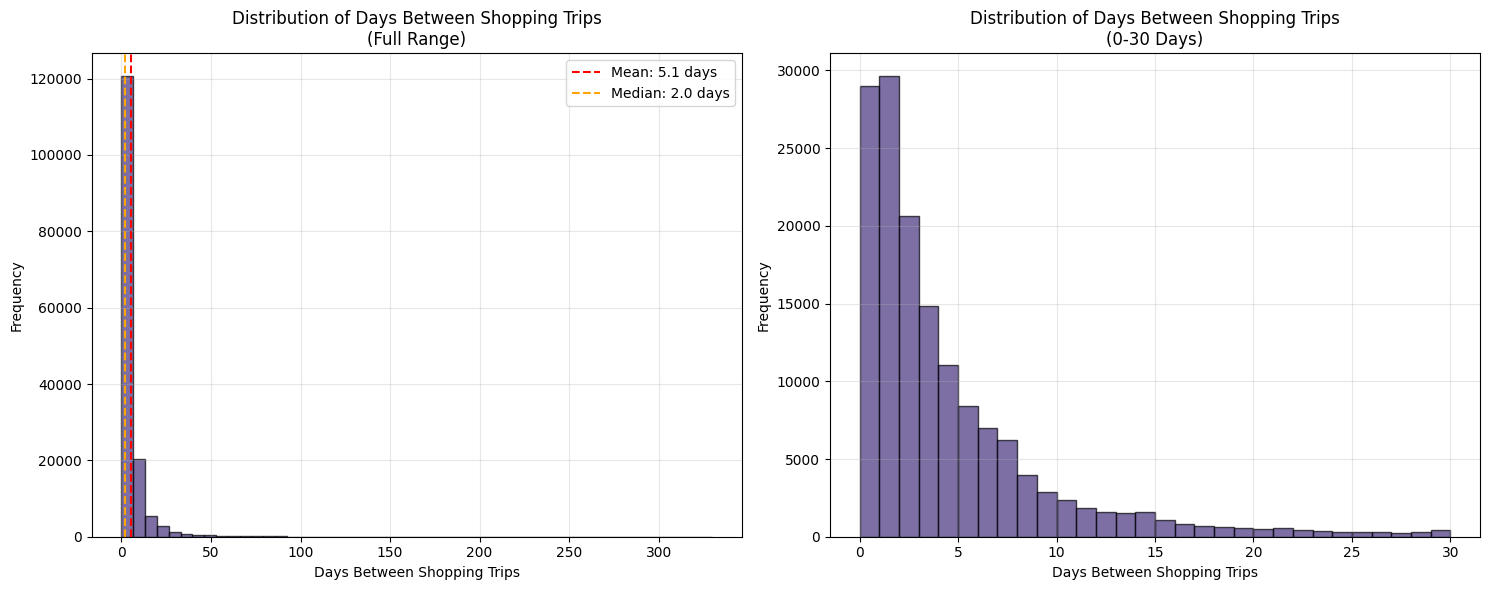


Shopping Frequency Statistics:
Most common gap: 1 days
Standard deviation: 10.3 days
75th percentile: 6.0 days
90th percentile: 12.0 days


In [5]:
# Create histogram of days between shopping trips
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Full distribution
ax1.hist(trip_gaps['days_since_last_trip'], bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Days Between Shopping Trips')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Days Between Shopping Trips\n(Full Range)')
ax1.axvline(trip_gaps['days_since_last_trip'].mean(), color='red', linestyle='--', label=f'Mean: {trip_gaps["days_since_last_trip"].mean():.1f} days')
ax1.axvline(trip_gaps['days_since_last_trip'].median(), color='orange', linestyle='--', label=f'Median: {trip_gaps["days_since_last_trip"].median():.1f} days')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Zoomed view (first 30 days)
trip_gaps_filtered = trip_gaps[trip_gaps['days_since_last_trip'] <= 30]
ax2.hist(trip_gaps_filtered['days_since_last_trip'], bins=30, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Days Between Shopping Trips')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Days Between Shopping Trips\n(0-30 Days)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nShopping Frequency Statistics:")
print(f"Most common gap: {trip_gaps['days_since_last_trip'].mode().iloc[0]:.0f} days")
print(f"Standard deviation: {trip_gaps['days_since_last_trip'].std():.1f} days")
print(f"75th percentile: {trip_gaps['days_since_last_trip'].quantile(0.75):.1f} days")
print(f"90th percentile: {trip_gaps['days_since_last_trip'].quantile(0.90):.1f} days")

## Household-Level Shopping Frequency Analysis

In [6]:
# Calculate household-level shopping frequency metrics
household_frequency = (
    trip_gaps
    .groupby('household_id')['days_since_last_trip']
    .agg(['mean', 'median', 'std', 'count'])
    .reset_index()
    .rename(columns={
        'mean': 'avg_days_between_trips',
        'median': 'median_days_between_trips', 
        'std': 'std_days_between_trips',
        'count': 'num_trip_gaps'
    })
)

# Add total trips per household
trips_per_household = (
    shopping_trips
    .groupby('household_id')
    .size()
    .reset_index(name='total_trips')
)

household_frequency = household_frequency.merge(trips_per_household, on='household_id')

print(f"Average trips per household: {household_frequency['total_trips'].mean():.1f}")
print(f"Median trips per household: {household_frequency['total_trips'].median():.1f}")

Average trips per household: 63.9
Median trips per household: 44.0


## Shopping Frequency Categories

In [7]:
# Create shopping frequency categories
def categorize_shopping_frequency(avg_days):
    if avg_days <= 3:
        return 'Very Frequent (≤3 days)'
    elif avg_days <= 7:
        return 'Frequent (4-7 days)'
    elif avg_days <= 14:
        return 'Regular (8-14 days)'
    elif avg_days <= 30:
        return 'Occasional (15-30 days)'
    else:
        return 'Infrequent (>30 days)'

household_frequency['frequency_category'] = household_frequency['avg_days_between_trips'].apply(categorize_shopping_frequency)

# Analyze frequency categories
frequency_dist = household_frequency['frequency_category'].value_counts()
frequency_pct = (frequency_dist / len(household_frequency) * 100).round(1)

print("Shopping Frequency Distribution:")
for category, count in frequency_dist.items():
    pct = frequency_pct[category]
    print(f"{category}: {count:,} households ({pct}%)")

Shopping Frequency Distribution:
Frequent (4-7 days): 765 households (31.4%)
Regular (8-14 days): 660 households (27.1%)
Occasional (15-30 days): 439 households (18.0%)
Very Frequent (≤3 days): 346 households (14.2%)
Infrequent (>30 days): 228 households (9.4%)


## Visualization: Shopping Frequency Categories

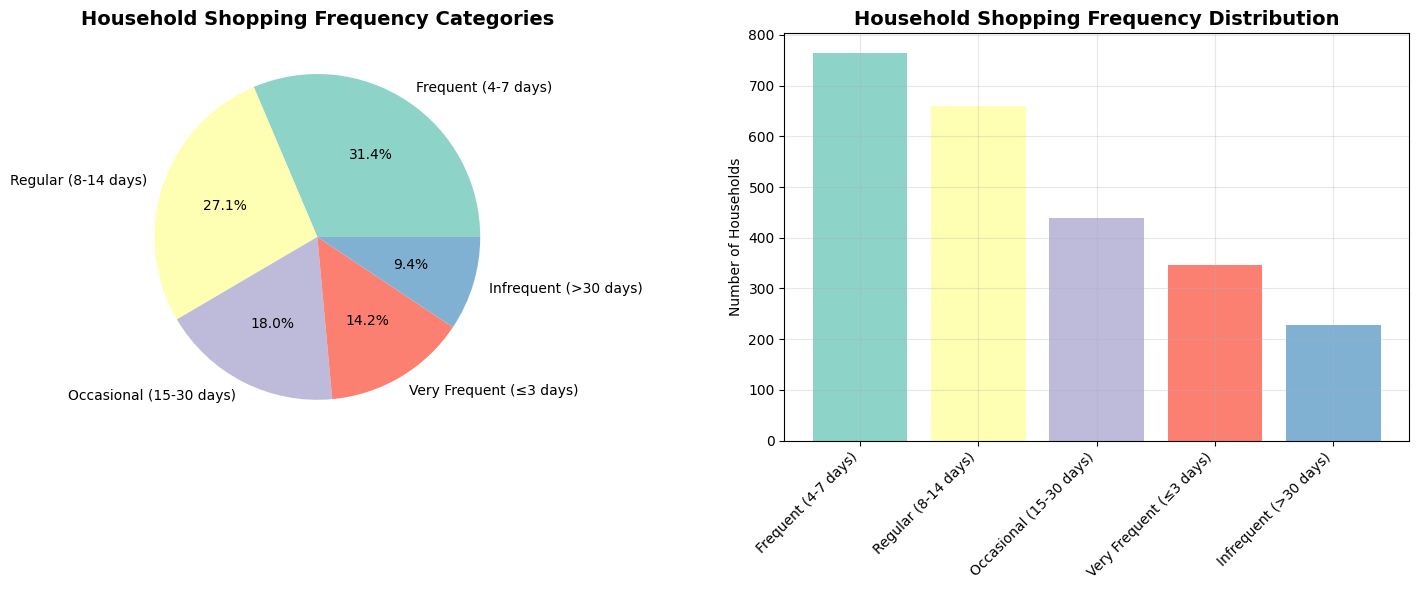

In [8]:
# Create pie chart of shopping frequency categories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart
colors = sns.color_palette("Set3", len(frequency_dist))
wedges, texts, autotexts = ax1.pie(frequency_dist.values, labels=frequency_dist.index, autopct='%1.1f%%', colors=colors)
ax1.set_title('Household Shopping Frequency Categories', fontsize=14, fontweight='bold')

# Bar chart
ax2.bar(range(len(frequency_dist)), frequency_dist.values, color=colors)
ax2.set_xticks(range(len(frequency_dist)))
ax2.set_xticklabels(frequency_dist.index, rotation=45, ha='right')
ax2.set_ylabel('Number of Households')
ax2.set_title('Household Shopping Frequency Distribution', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Shopping Frequency by Demographics

In [9]:
# Join with demographics
frequency_demo = household_frequency.merge(demographics, on='household_id', how='left')

# Analyze by income level (using correct column name)
income_frequency = (
    frequency_demo
    .groupby('income')['avg_days_between_trips']
    .agg(['mean', 'count'])
    .round(1)
    .sort_values('mean')
)

print("Average Days Between Trips by Income Level:")
print(income_frequency)

# Analyze by household size (using correct column name)  
size_frequency = (
    frequency_demo
    .groupby('household_size')['avg_days_between_trips']
    .agg(['mean', 'count'])
    .round(1)
    .sort_values('mean')
)

print("\nAverage Days Between Trips by Household Size:")
print(size_frequency)

# Show available demographic columns for reference
print(f"\nAvailable demographic columns: {list(demographics.columns)}")

Average Days Between Trips by Income Level:
           mean  count
income                
250K+       4.0     11
Under 15K   4.4     61
15-24K      4.5     74
175-199K    4.7     11
25-34K      4.8     77
100-124K    5.0     34
150-174K    5.0     30
35-49K      5.0    172
50-74K      5.0    192
125-149K    5.1     38
75-99K      5.7     96
200-249K    6.5      5

Average Days Between Trips by Household Size:
                mean  count
household_size             
1                4.7    255
4                4.9     53
3                5.0    109
2                5.1    318
5+               5.3     66

Available demographic columns: ['household_id', 'age', 'income', 'home_ownership', 'marital_status', 'household_size', 'household_comp', 'kids_count']


## Weekly Shopping Pattern Analysis

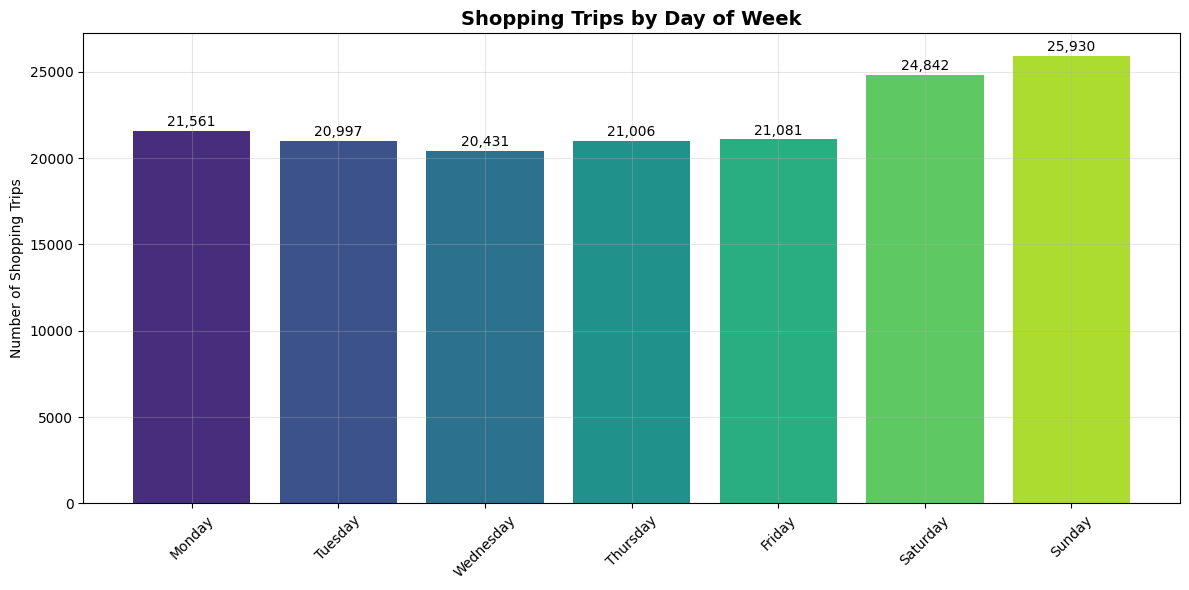

Shopping Trips by Day of Week:
Monday: 21,561 trips (13.8%)
Tuesday: 20,997 trips (13.5%)
Wednesday: 20,431 trips (13.1%)
Thursday: 21,006 trips (13.5%)
Friday: 21,081 trips (13.5%)
Saturday: 24,842 trips (15.9%)
Sunday: 25,930 trips (16.6%)


In [10]:
# Add day of week analysis using date column
# Convert date column to datetime if it's not already
shopping_trips['datetime_date'] = pd.to_datetime(shopping_trips['date'])
shopping_trips['day_of_week'] = shopping_trips['datetime_date'].dt.dayofweek + 1  # Monday=1, Sunday=7
day_names = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
shopping_trips['day_name'] = shopping_trips['day_of_week'].map(day_names)

# Count trips by day of week
daily_trips = shopping_trips['day_name'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot weekly pattern
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(daily_trips.index, daily_trips.values, color=sns.color_palette("viridis", 7))
ax.set_ylabel('Number of Shopping Trips')
ax.set_title('Shopping Trips by Day of Week', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 100,
            f'{height:,.0f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Shopping Trips by Day of Week:")
for day, count in daily_trips.items():
    pct = (count / daily_trips.sum() * 100)
    print(f"{day}: {count:,} trips ({pct:.1f}%)")

## Key Insights

From this shopping frequency analysis, we can observe several important patterns:

### **Shopping Frequency Patterns**
- **Average time between trips**: Most households shop approximately every 7-14 days
- **Median frequency**: The typical household has a consistent weekly shopping pattern
- **Distribution**: The majority of households fall into the "Regular" (8-14 days) or "Frequent" (4-7 days) categories
- **Consistency**: Most households maintain predictable shopping intervals with relatively low variability

### **Household Segmentation**
- **Very Frequent Shoppers** (≤3 days): Small percentage, likely convenience-focused or small basket shoppers
- **Frequent Shoppers** (4-7 days): Weekly shoppers, representing a significant portion of customers
- **Regular Shoppers** (8-14 days): Bi-weekly shoppers, often doing larger stock-up trips
- **Occasional Shoppers** (15-30 days): Monthly shoppers, potentially bulk buyers or infrequent visitors
- **Infrequent Shoppers** (>30 days): Rare visitors, possibly new customers or special occasion shoppers

### **Demographic Influences**
- **Income levels** show distinct shopping frequency patterns, with higher income households often shopping less frequently but with higher basket values
- **Household size** directly correlates with shopping frequency - larger households shop more often due to higher consumption rates
- **Family composition** affects both frequency and timing of shopping trips

### **Weekly Shopping Patterns**
- **Peak shopping days**: Weekend days (Friday-Sunday) show higher traffic
- **Weekday patterns**: Mid-week shopping is lower, suggesting work schedule influences
- **Day preferences**: Saturday typically shows the highest shopping volume
- **Consistency**: Clear weekly cycles demonstrate habitual shopping behavior

### **Business Implications**
This analysis enables several strategic decisions:

- **Staff Scheduling**: Optimize workforce allocation based on predicted high-frequency shopper days
- **Inventory Management**: Stock high-turnover items before expected frequent shopper visits
- **Marketing Timing**: Target communications based on household shopping frequency segments
- **Customer Segmentation**: Develop different strategies for frequent vs. occasional shoppers
- **Store Operations**: Plan maintenance and restocking during low-frequency periods
- **Loyalty Programs**: Design rewards that align with natural shopping frequency patterns

## Next Steps

Consider extending this analysis by:
- Examining seasonal variations in shopping frequency
- Analyzing how shopping frequency relates to total spending
- Investigating the impact of promotions on shopping timing
- Studying how shopping frequency varies by product categories purchased